In [1]:
"""This file contains the pipeline for training and evaluating the GCN on the data."""
import os
import sys
import random
import numpy as np
import pandas as pd
import datetime
from typeguard import typechecked
import pickle
import matplotlib.pyplot as plt

import networkx
import torch
from torch_geometric.data import Data, DataLoader, Batch
from torch_geometric.utils.convert import from_networkx
from torch.optim.lr_scheduler import StepLR,ReduceLROnPlateau
from torch_geometric.loader import DataLoader, ClusterLoader, NeighborLoader
from tqdm import tqdm

sys.path.append("/home/jovyan/20230406_ArticleClassifier/ArticleClassifier")

import src.general.global_variables as gv

sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname('data_loader.py'), os.path.pardir)))
from src.data.data_loader import DataLoader
from src.data.data_processing import standardise_embeddings, convert_networkx_to_torch, get_mask, gather_set_indices, drop_keyword_edges
from src.visualization.visualize import tsne, plot_metrics_during_training, plot_label_count_in_datasets, plot_performance_per_label
from src.general.utils import cc_path
from src.models.evaluation import Metrics


import matplotlib.pyplot as plt

from src.models.graph_network_models.single_stream_gat import GAT
from src.models.graph_network_models.single_stream_gat_label_emb import GAT_label
from src.models.graph_network_models.single_stream_gin import GIN
from src.models.graph_network_models.single_stream_gcn import GCN
from src.models.graph_network_models.single_stream_graphtransformer import GraphTransformer
from src.models.graph_network_models.single_stream_sage import SAGE


from src.models.graph_network_models.dual_stream_gcn import dualGCN
from src.models.graph_network_models.dual_stream_gat import dualGAT

from src.models.graph_training import evaluate_metrics, construct_metric_storage, retrieve_and_store_metrics,train_model,train_batch, train 

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


def get_optimizer(graph_optimizer, args, params):
    """
    Initialise the specified optimizer.
    Args:
        graph_optimizer (str): name of desired optimizer 
        args (dict): settings for optimizer 
        params (): model parameters 

    Returns:
        initialised optimiser
    """
    if graph_optimizer == 'adam':
        optimizer = torch.optim.Adam(params, lr=args['graph_lr'], weight_decay=args['graph_weight_decay'])
    elif graph_optimizer == 'noamopt':
        total_params = sum(
            param.numel() for param in params
        )

        optimizer = NoamOpt(total_params, 500,
                torch.optim.Adam(params, lr=0, betas=(0.9, 0.98), eps=1e-9))
    else:
        assert False, f'Graph optimizer {graph_optimizer} not recognised, use one of [adam, noamopt]'
        
    return optimizer

def get_loss_fn(graph_loss, args):
    """
    Initialise the specified loss function.
    
    Args:
        graph_loss (str): name of desired loss function 
        args (dict): settings for loss function 

    Returns:
        initialised loss function
    """
    if graph_loss == 'BCELoss':
        criterion = torch.nn.BCELoss()
    elif graph_loss == 'FocalLoss':
        criterion = FocalLoss(gamma=args['graph_fl_gamma'], alpha=args['graph_fl_alpha'])
    else:
        assert False, f'Loss function {graph_loss} not recognised, use one of [BCELoss, FocalLoss]'
    
    return criterion
        

def initiate_model(gnn_type, model_parameters, num_features, num_labels):
    if gnn_type == 'GCN':
        model = GCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels)
    elif gnn_type == 'GAT':
        model = GAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels, num_conv_layers=model_parameters['num_conv_layers'],
                    heads=model_parameters['heads'], embedding_size=model_parameters['embedding_size'],
                    dropout=model_parameters['dropout'])
    elif gnn_type == 'GAT_label':
        model = GAT_label(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels, num_conv_layers=model_parameters['num_conv_layers'],
                    heads=model_parameters['heads'], embedding_size=model_parameters['embedding_size'],
                    dropout=model_parameters['dropout'])
    elif gnn_type == 'GIN':
        model = GIN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels, num_conv_layers=model_parameters['num_conv_layers'],
                    embedding_size=model_parameters['embedding_size'])
    elif gnn_type == 'dualGCN':
        model = dualGCN(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels)
    elif gnn_type == 'dualGAT':
        model = dualGAT(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                        num_labels=num_labels, num_conv_layers=model_parameters['num_conv_layers'],
                        heads=model_parameters['heads'], embedding_size=model_parameters['embedding_size'],
                        dropout=model_parameters['dropout'])
    elif gnn_type == 'SAGE':
        model = SAGE(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
            num_labels=num_labels)
    elif gnn_type == 'GraphTransformer':
        model = GraphTransformer(hidden_channels=model_parameters['hidden_channels'], num_features=num_features,
                    num_labels=num_labels,
                    heads=model_parameters['heads'])    
    
    else:
        assert False, f'Model type: {gnn_type} not recognised, must be in: ["GCN", "GAT", "GAT_label", "GIN", "dualGCN", "dualGAT", "SAGE", "GraphTransformer"]'

    return model.to(device)

## Set model parameters

In [2]:
# current models to choose from: ["GCN", "GAT", 'SAGE', 'GraphTransformer', "dualGCN", "dualGAT"]
# current embedding_types to choose from: ["general", "label_specific", 'scibert']

now = datetime.datetime.now()
run_id = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
today = datetime.date.today()
time = now.strftime("%H-%M-%S")


gnn_type = 'GAT'
subsample_size = 56337
total_dataset_size = 56337
data_type_to_use = ['keyword']
embedding_type = 'scibert'
edge_weight_threshold = 1/10

# just for setting them if no pretraining happens
pretrain_lr = None
pretrain_weight_decay = None
pretrain_optimizer = None
pretrain_loss = None
pretrain_epochs = None

all_model_parameters = {
    "GAT": {
        'embedding_size': 128,
        'hidden_channels': 128,
        'heads': 8,
        'num_conv_layers': 3,
        'dropout': 0.3
    },
    "GAT_label": {
        'embedding_size': 128,
        'hidden_channels': 64,
        'heads': 8,
        'num_conv_layers': 3,
        'dropout': 0.3
    },
    "GraphTransformer": {
        'hidden_channels': 32,
        'heads': 8
    },
    "GCN": {
        'hidden_channels': 64
    },
    "SAGE": {
        'hidden_channels': 32,
        'heads': 4
    },
    "dualGAT": {
        'hidden_channels': 64,
        'heads': 4,
        'embedding_size': 128,
        'num_conv_layers': 3,
        'dropout': 0.3
    },
    "dualGCN": {
        'hidden_channels': 32
    },
    "GIN": {
        'embedding_size': 128,
        'hidden_channels': 64,
        'num_conv_layers': 3
    }
}

## Load and process the data

In [3]:
# load all the data
print('Start loading data...')
loc_dict = {
    'processed_csv': cc_path('data/processed/canary/articles_cleaned.csv'),
    'abstract_embeddings': cc_path('data/processed/canary/embeddings_fasttext_20230410.csv'),
    'scibert_embeddings': cc_path('data/processed/canary/embeddings_scibert_finetuned_20230425.csv'),
    'keyword_network': cc_path('data/processed/canary/keyword_network_weighted.pickle'),
    'xml_embeddings': cc_path('data/processed/canary/embeddings_xml.ftr'),
    'author_network': cc_path('data/processed/canary/author_network.pickle'), 
    'label_network': cc_path('data/processed/canary/label_network_weighted.pickle')
}
data_loader = DataLoader(loc_dict)
processed_df = data_loader.load_processed_csv()
author_networkx = data_loader.load_author_network()
keyword_network = data_loader.load_keyword_network()
label_network = data_loader.load_label_network()

label_data = from_networkx(label_network)

all_data = {
    'author': author_networkx,
    'keyword': keyword_network,
    'label': label_data
}

Start loading data...


In [4]:
# process all data
if embedding_type == 'general':
    embedding_df = data_loader.load_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'scibert':
    embedding_df = data_loader.load_scibert_embeddings_csv()
    embedding_df = standardise_embeddings(embedding_df)
elif embedding_type == 'label_specific':
    embedding_df = data_loader.load_xml_embeddings()

# process the labels we want to select now
label_columns = processed_df.loc[:, ~processed_df.columns.isin(
    ['file_name', 'title', 'keywords', 'abstract', 'abstract_2', 'authors', 'organization', 'chemicals',
     'num_refs', 'date-delivered', 'labels_m', 'labels_a'])]
label_columns.loc[:, label_columns.columns.difference(['pui'])] = label_columns.loc[
    :, label_columns.columns.difference(['pui'])].astype(str)


Start processing data...
Standardising embeddings...


## visualise the effect of an edge weight threshold

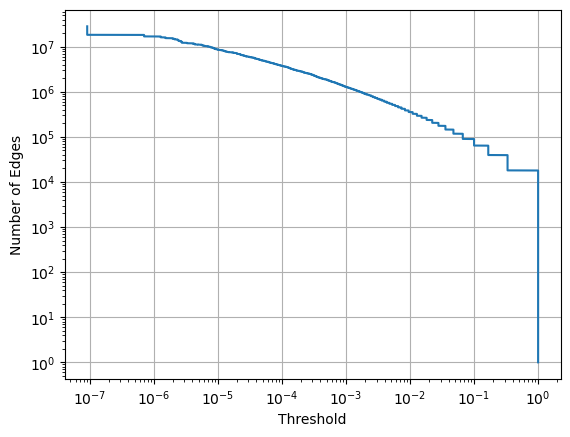

In [5]:
plot_threshold_effect_on_edges(keyword_network, cc_path(f'reports/figures/remaining_edges_for_thresholds.png'))

In [5]:
keyword_network = drop_keyword_edges(keyword_network, edge_weight_threshold)

In [6]:
# get down-sampled networks
available_nodes = list(set(author_networkx.nodes) & set(keyword_network.nodes) & set(embedding_df.pui.to_list()))
sampled_nodes = random.sample(available_nodes, subsample_size)
sampled_author = author_networkx.subgraph(sampled_nodes).copy()
sampled_keyword = keyword_network.subgraph(sampled_nodes).copy()

# nodes can only have incremental integers as labels, so we create a mapping to remember which pui is which idx
print(f'Number of nodes in sampled author network: {len(sampled_author.nodes)}')
print(f'Number of nodes in sampled keyword network: {len(sampled_keyword.nodes)}')

Number of nodes in sampled author network: 56337
Number of nodes in sampled keyword network: 56337


In [7]:
train_indices, val_indices, test_indices, node_label_mapping = gather_set_indices(subsample_size, total_dataset_size, sampled_author)

## Visualise the label occurrence distribution

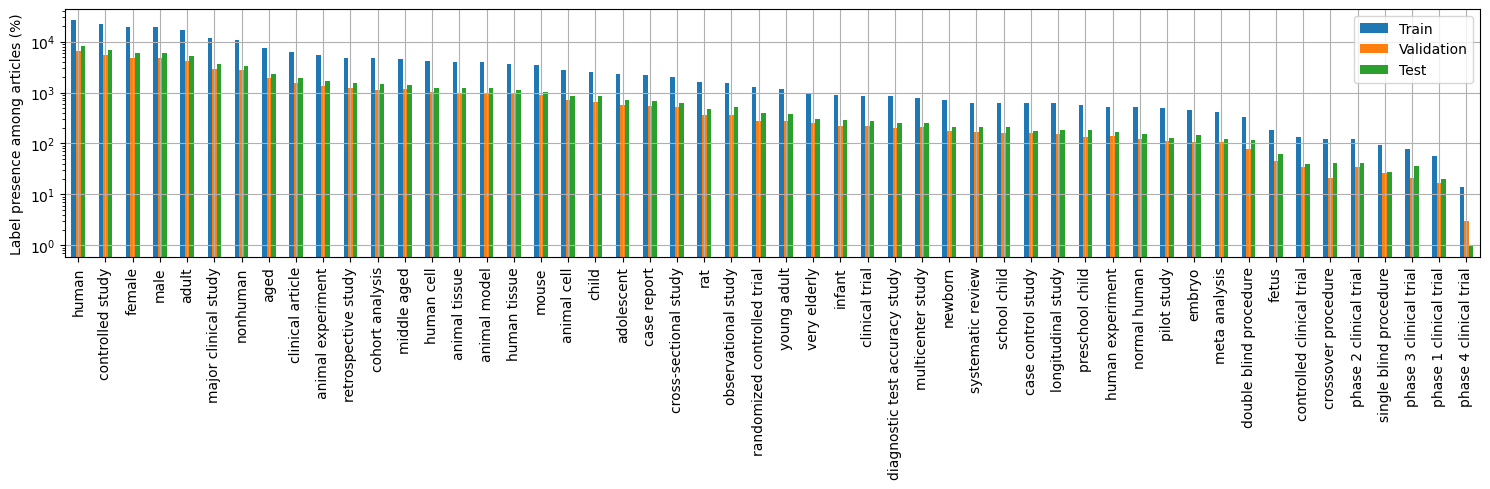

In [18]:
# plot_label_count_in_datasets(label_columns, train_puis, val_puis, test_puis, 
#                              cc_path(f'reports/figures/data_split_label_occurrences/label_distribution.png'))

In [8]:
# create train and test split
print('Creating torch datasets...')

train_mask = get_mask(train_indices, len(sampled_author))
val_mask = get_mask(val_indices, len(sampled_author))
test_mask = get_mask(test_indices, len(sampled_author))
author_data = convert_networkx_to_torch(sampled_author, embedding_df, label_columns, train_mask, val_mask, test_mask,
                                 node_label_mapping, embedding_type)
keyword_data = convert_networkx_to_torch(sampled_keyword, embedding_df, label_columns, train_mask, val_mask, test_mask,
                                  node_label_mapping, embedding_type)

author_data.to(device)
keyword_data.to(device)

Creating torch datasets...


Data(x=[56337, 768], edge_index=[2, 119992], y=[56337, 52], train_mask=[56337], val_mask=[56337], test_mask=[56337], edge_weight=[31870])

## Easy testing of model classes

# Modelling

## Initiate Model

In [9]:
# initiate the model
model = initiate_model(
    gnn_type,
    all_model_parameters[gnn_type],
    num_features=author_data.x.shape[1],
    num_labels=len(label_columns.columns) - 1
)
model.to(device)

GAT(
  (convs): ModuleList(
    (0): GATv2Conv(768, 128, heads=8)
    (1-2): 2 x GATv2Conv(1024, 128, heads=8)
  )
  (linear_final_end): Linear(in_features=1024, out_features=52, bias=True)
)

## pretrain Model

In [26]:
from src.models.pretraining import NegativeEdge, BatchAE, train_pretrain, DataLoaderAE


transform =  NegativeEdge()
transformed_author_data = transform(keyword_data)
pretrain_lr = 0.001
pretrain_weight_decay = 0.00001
pretrain_optimizer = 'adam'
pretrain_loss = 'BCEWithLogits'

#set up optimizer and criterion
if pretrain_optimizer == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=pretrain_lr, weight_decay=pretrain_weight_decay)

if pretrain_loss == 'BCEWithLogits':
    criterion_pretrain = torch.nn.BCEWithLogitsLoss()


In [ ]:

#optimizer = optim.Adam(model.graph_pred_linear.parameters(), lr=args.lr, weight_decay=args.decay)    
all_torch_data = {
    'author': author_data,
    'keyword': keyword_data,
    'label': label_data
}

train_acc = 0
pretrain_epochs = 800
train_losses = []
train_accs = []
for epoch in (pbar := tqdm(range(1, pretrain_epochs))):
    model, train_acc, train_loss = train_pretrain(model, device, None, optimizer, BatchAE([transformed_author_data]).batch[0], criterion_pretrain, all_torch_data, data_type_to_use)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    pbar.set_description(f'Train acc: {train_acc}, Train loss: {train_loss}')

fig, ax1 = plt.subplots()
ax1.plot(np.arange(1, len(train_losses) + 1),train_accs , label='Train accuracy', c='blue')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

ax2 = ax1.twinx()
ax2.set_ylabel('Loss')
ax2.plot(np.arange(1, len(train_accs) + 1), train_losses, label='Loss', c='green')

plt.title(f'Pretraining - edge prediction')
fig.legend(loc='lower right', fontsize='x-large')
plt.grid()
plt.show()

torch.save(model, cc_path(f'models/pretrained_graphs/{run_id}_pretained.pt'))

## run test prediction

In [9]:
all_torch_data = {
    'author': author_data,
    'keyword': keyword_data,
    'label': label_data
}

# get the output of an untrained model
data = [all_torch_data[datatype] for datatype in data_type_to_use]
data_inputs = [d for data_object in data for d in (data_object.x.float(), data_object.edge_index)]

if 'label' in data_type_to_use:
    data_inputs.append(all_torch_data['label'].edge_weight.float())

In [11]:
model.eval()

out = model(*data_inputs)
print('The predictions of the test set before training: ', out[author_data.test_mask].detach().cpu().numpy())

The predictions of the test set before training:  [[0.49316064 0.51845413 0.47667074 ... 0.37825817 0.5563986  0.49608436]
 [0.48035443 0.46671227 0.4627159  ... 0.4126556  0.46121705 0.56125635]
 [0.5768932  0.42601654 0.44792458 ... 0.5446251  0.5287502  0.5126944 ]
 ...
 [0.49806762 0.5884627  0.45204613 ... 0.4313255  0.57272595 0.4905581 ]
 [0.5271426  0.3534239  0.51501244 ... 0.47360107 0.49650776 0.5355409 ]
 [0.49315327 0.4104459  0.4931575  ... 0.48602495 0.49607298 0.56980056]]


### Set model training parameters

In [12]:
# set training parameters
graph_optimizer = 'adam'
graph_lr = 0.00001
graph_weight_decay = 1e-4
graph_loss = 'BCELoss'
graph_fl_gamma = 2.8
graph_fl_alpha = 0.25
scheduler = None

optimizer_args = {
    "graph_lr": graph_lr,
    "graph_weight_decay": graph_weight_decay
}

loss_args = {
    'graph_fl_gamma': graph_fl_gamma,
    'graph_fl_alpha': graph_fl_alpha
}

optimizer = get_optimizer(graph_optimizer, optimizer_args, model.parameters())
criterion = get_loss_fn(graph_loss, loss_args)



### Train model

In [17]:
# def train_model(model, data, graph_num_epochs, optimizer, scheduler, criterion, graph_optimizer, data_type_to_use,
#                 all_torch_data, use_batches = True):
#     """
#     Train a model for the full number of epochs.

#     Args:
#         model (): the Graph model object
#         data (): list with torch geometric data object necessary for model
#         graph_num_epochs (int): number of epochs to train
#         optimizer (): torch optimizer for model
#         scheduler (): learning rate scheduler if used
#         criterion (): loss criterion
#         graph_optimizer (str): name of optimizer
#         data_type_to_use (list[list]): data types to use
#         all_torch_data (dict): dict with all data to use
#         use_batches (bool): whether to use mini-batches

#     Returns:
#         Best model after training, the metrics over time
#     """
#     # define names of what to store
#     dataset_names = ['train', 'val', 'test']
#     all_metric_names = evaluate_metrics(model, data, dataset='train').keys()

#     # create storage locations
#     all_metrics = construct_metric_storage(dataset_names, all_metric_names)
#     loss_all = []

#     # define loaders if using batches
#     if use_batches:
#         loaders = [NeighborLoader(d, num_neighbors=[30] * 2, batch_size=128) for d in data]

#     # go over each epoch
#     best_score = 0
#     curr_scores = ''
#     for epoch in (pbar := tqdm(range(1, graph_num_epochs), position=0)):

#         if use_batches:
#             loss = train_batch(model, loaders, optimizer, scheduler, criterion, graph_optimizer, pbar, epoch,
#                                curr_scores, data_type_to_use)
#         else:
#             loss = train(model, data, optimizer, scheduler, criterion, graph_optimizer, data_type_to_use, all_torch_data)

#         # gather the metrics for all datasets
#         all_metrics = retrieve_and_store_metrics(all_metrics, all_metric_names, dataset_names, model, data,
#                                                  data_type_to_use, all_torch_data)
#         loss_all.append(loss)

#         # define text for progressbar
#         curr_scores = f"Train - F1 {all_metrics['train']['Macro F1 score'][-1]}, " \
#                       f"Val - F1 {all_metrics['val']['Macro F1 score'][-1]}"

#         # save the best model if we see improvement
#         if all_metrics['val']['Macro F1 score'][-1] > best_score:
#             best_model = model

#     return best_model, all_metrics

In [13]:
# train model
graph_num_epochs = 500

best_model = train_model(model, data, graph_num_epochs, optimizer, scheduler, criterion, graph_optimizer, use_batches=True, data_type_to_use=data_type_to_use, all_torch_data=all_torch_data)

best_model, all_metrics = best_model
torch.save(best_model, cc_path(f'models/supervised_graphs/{run_id}_supervised.pt'))
    


Epoch: 499, Train - F1 0.6029092869894443, Val - F1 0.5674457541217535, Batch: 441/441, Loss: 0.0832: 100%|██████████| 499/499 [44:53<00:00,  5.40s/it]


NameError: name 'test_metrics' is not defined

In [15]:
best_model, all_metrics = best_model


### Model Evaluation

Evaluating model performance...
The metrics:  {'Precision': [0.7865085248332098, 0.8810232727714651, 0.7407026311921211, 0.7377049180327869, 0.9002173125679102, 0.855607134131444, 0.7862988075754033, 0.9166666666666666, 0.9492610837438423, 0.8546562228024369, 0.8773240660295395, 0.7195652173913043, 0.8666666666666667, 0.0, 0.7943716560643721, 0.9067629678266579, 0.9180327868852459, 0.7069672131147541, 0.8393574297188755, 0.7639751552795031, 0.9271470774424985, 0.8333333333333334, 0.9721142857142857, 0.8035030103995622, 0.7063492063492064, 0.7747035573122529, 0.7117988394584139, 0.818407960199005, 0.8857287963433215, 0.9102277348515657, 0.7954545454545454, 0.6987212276214834, 0.9324324324324325, 0.7433155080213903, 0.7425373134328358, 0.9329956031351558, 0.75, 0.9346485819975339, 0.42857142857142855, 0.7222222222222222, 0.5, 0.0, 0.9143835616438356, 0.554945054945055, 0.8684444444444445, 0.9484240687679083, 0.9195769798327594, 0.6732673267326733, 0.0, 0.8561525129982669, 0.6440677966101

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/20230406_ArticleClassifier/ArticleClassifier/reports/figures/classification_results/2023-05-02/15-48-08/20230502154808_GAT_F1 score_label.png'

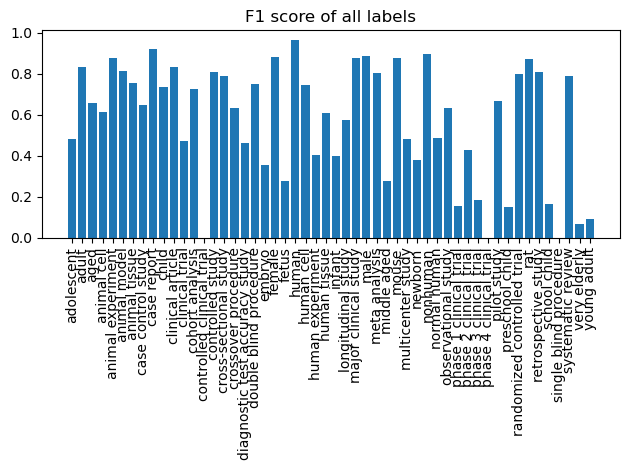

In [19]:
# image_path = cc_path(f'reports/figures/classification_results/{today}/')
# if not os.path.exists(image_path):
#     os.mkdir(image_path)
# os.mkdir(image_path + f'{time}/')

# plot metric developement during traing
for metric in ['F1 score', "precision", 'recall']:
    if 'Micro' in metric or 'Macro' in metric:
        plot_metrics_during_training(all_metrics['train'][metric], all_metrics['test'][metric], loss_all, model_name=gnn_type, metric_name=metric, today=today, time=time)
        print(f"The max {metric} value: ", max(test_metrics_all[metric]))


# get the test accuracy
print('Evaluating model performance...')
model.eval()
train_end_metrics = evaluate_metrics(model, data, dataset='train', show=True)
val_end_metrics = evaluate_metrics(model, data, dataset='val', show=True)
test_end_metrics = evaluate_metrics(model, data, dataset='test', show=True)

for metric in ['F1 score', "Precision", 'Recall']:
    if not 'Micro' in metric and not 'Macro' in metric:
        plot_performance_per_label(metric, test_end_metrics[metric], label_columns.columns.difference(['pui']), run_id, today, time, gnn_type)
        
# visualize(out, color=data.y.argmax(dim=1))

### train classification head on graph node embeddings

In [10]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
import lightgbm as gbm

In [11]:
resume_from_checkpoint = True
if resume_from_checkpoint:
    restore_run_id = '20230502154808'
    model, res = torch.load(cc_path(f'models/supervised_graphs/{restore_run_id}_supervised.pt'), map_location=torch.device('cpu'))
else:
    model = best_model

# model.to('cpu')
# loaders = [d.to('cpu') for d in data]
# data_inputs = [data_input.to('cpu') for data_input in data_inputs]

graph_created_embeddings = model.forward(*data_inputs, return_embeddings=True)

X_train_graph_embeddings = graph_created_embeddings[data[0].train_mask].detach().cpu().numpy()
X_val_graph_embeddings = graph_created_embeddings[data[0].val_mask].detach().cpu().numpy()
X_test_graph_embeddings = graph_created_embeddings[data[0].test_mask].detach().cpu().numpy()

y_train_graph_embeddings = data[0].y[data[0].train_mask].detach().cpu().numpy()
y_val_graph_embeddings = data[0].y[data[0].val_mask].detach().cpu().numpy()
y_test_graph_embeddings = data[0].y[data[0].test_mask].detach().cpu().numpy()

In [12]:
from data.mlsmote import get_minority_instance, MLSMOTE

X = pd.DataFrame(X_train_graph_embeddings)
y = pd.DataFrame(y_train_graph_embeddings)

X_sub, y_sub = get_minority_instance(X, y)   #Getting minority instance of that datframe
X_res,y_res =MLSMOTE(X_sub, y_sub, 2000)

In [13]:
X_train_graph_embeddings = np.concatenate((X_train_graph_embeddings, X_res.to_numpy()))
y_train_graph_embeddings = np.concatenate((y_train_graph_embeddings, y_res.to_numpy()))

In [14]:
# create a classifier for each class
lgbm_params = {
    'n_estimators': 700,
    'is_unbalance': True,
    'n_jobs': -1,
    'learning_rate': 0.01,
    'subsample': 0.9,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'colsample_bytree': 0.8,
    'boosting_type': 'dart'
}

num_labels = 52
clfs = []
for i in range(num_labels):
    clfs.append(gbm.LGBMClassifier(**lgbm_params))

already_fitted = False

In [15]:
for i in tqdm(range(num_labels)):
    if not already_fitted:
        clfs[i] = clfs[i].fit(X_train_graph_embeddings, y_train_graph_embeddings[:, i], callbacks=[gbm.log_evaluation(period=100), gbm.early_stopping(30)], eval_set=(X_val_graph_embeddings, y_val_graph_embeddings[:, i]))
    elif already_fitted:
        clfs[i] = clfs[i].fit(X_train_graph_embeddings, y_train_graph_embeddings[:, i], callbacks=[gbm.log_evaluation(period=100), gbm.early_stopping(30)], eval_set=(X_val_graph_embeddings, y_val_graph_embeddings[:, i]), init_model=clfs[i])
    
already_fitted = True

# Save the list of trained models to a file
with open(cc_path(f'models/classification_heads/{run_id}_classification_head.pkl'), 'wb') as f:
    pickle.dump(clfs, f)



  0%|          | 0/52 [00:00<?, ?it/s]/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.27481
[200]	valid_0's binary_logloss: 0.333687
[300]	valid_0's binary_logloss: 0.320214
[400]	valid_0's binary_logloss: 0.30468
[500]	valid_0's binary_logloss: 0.291531
[600]	valid_0's binary_logloss: 0.280718


  2%|▏         | 1/52 [00:38<33:02, 38.88s/it]

[700]	valid_0's binary_logloss: 0.274232


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.521831
[200]	valid_0's binary_logloss: 0.467429
[300]	valid_0's binary_logloss: 0.423539
[400]	valid_0's binary_logloss: 0.395392
[500]	valid_0's binary_logloss: 0.376182
[600]	valid_0's binary_logloss: 0.371416


  4%|▍         | 2/52 [01:20<33:37, 40.36s/it]

[700]	valid_0's binary_logloss: 0.363979


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.438342
[200]	valid_0's binary_logloss: 0.435761
[300]	valid_0's binary_logloss: 0.407959
[400]	valid_0's binary_logloss: 0.38739
[500]	valid_0's binary_logloss: 0.372491
[600]	valid_0's binary_logloss: 0.365098


  6%|▌         | 3/52 [02:00<32:45, 40.10s/it]

[700]	valid_0's binary_logloss: 0.358783


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.245575
[200]	valid_0's binary_logloss: 0.282498
[300]	valid_0's binary_logloss: 0.260078
[400]	valid_0's binary_logloss: 0.23926
[500]	valid_0's binary_logloss: 0.222424
[600]	valid_0's binary_logloss: 0.211903


  8%|▊         | 4/52 [02:32<29:35, 37.00s/it]

[700]	valid_0's binary_logloss: 0.203795


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.29114
[200]	valid_0's binary_logloss: 0.279639
[300]	valid_0's binary_logloss: 0.233824
[400]	valid_0's binary_logloss: 0.198449
[500]	valid_0's binary_logloss: 0.170568
[600]	valid_0's binary_logloss: 0.15983


 10%|▉         | 5/52 [03:02<27:01, 34.50s/it]

[700]	valid_0's binary_logloss: 0.146884


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.256613
[200]	valid_0's binary_logloss: 0.266908
[300]	valid_0's binary_logloss: 0.230493
[400]	valid_0's binary_logloss: 0.200207
[500]	valid_0's binary_logloss: 0.176149
[600]	valid_0's binary_logloss: 0.165951


 12%|█▏        | 6/52 [03:33<25:31, 33.30s/it]

[700]	valid_0's binary_logloss: 0.1546


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.269569
[200]	valid_0's binary_logloss: 0.284295
[300]	valid_0's binary_logloss: 0.25176
[400]	valid_0's binary_logloss: 0.225322
[500]	valid_0's binary_logloss: 0.204928
[600]	valid_0's binary_logloss: 0.195334


 13%|█▎        | 7/52 [04:04<24:25, 32.57s/it]

[700]	valid_0's binary_logloss: 0.186181


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.136613
[200]	valid_0's binary_logloss: 0.205051
[300]	valid_0's binary_logloss: 0.19167
[400]	valid_0's binary_logloss: 0.1716
[500]	valid_0's binary_logloss: 0.151869
[600]	valid_0's binary_logloss: 0.138879


 15%|█▌        | 8/52 [04:43<25:26, 34.70s/it]

[700]	valid_0's binary_logloss: 0.127118


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.178193
[200]	valid_0's binary_logloss: 0.204873
[300]	valid_0's binary_logloss: 0.172077
[400]	valid_0's binary_logloss: 0.14135
[500]	valid_0's binary_logloss: 0.114556
[600]	valid_0's binary_logloss: 0.103086


 17%|█▋        | 9/52 [05:17<24:37, 34.36s/it]

[700]	valid_0's binary_logloss: 0.0887082


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.239696
[200]	valid_0's binary_logloss: 0.274373
[300]	valid_0's binary_logloss: 0.247664
[400]	valid_0's binary_logloss: 0.222778
[500]	valid_0's binary_logloss: 0.202154
[600]	valid_0's binary_logloss: 0.191742


 19%|█▉        | 10/52 [05:53<24:20, 34.78s/it]

[700]	valid_0's binary_logloss: 0.181231


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.355451
[200]	valid_0's binary_logloss: 0.341981
[300]	valid_0's binary_logloss: 0.298952
[400]	valid_0's binary_logloss: 0.266286
[500]	valid_0's binary_logloss: 0.241402
[600]	valid_0's binary_logloss: 0.232263


 21%|██        | 11/52 [06:30<24:17, 35.54s/it]

[700]	valid_0's binary_logloss: 0.22101


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.188261
[200]	valid_0's binary_logloss: 0.244112
[300]	valid_0's binary_logloss: 0.223964
[400]	valid_0's binary_logloss: 0.201775
[500]	valid_0's binary_logloss: 0.18201
[600]	valid_0's binary_logloss: 0.170366


 23%|██▎       | 12/52 [07:06<23:54, 35.87s/it]

[700]	valid_0's binary_logloss: 0.159375


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.356353
[200]	valid_0's binary_logloss: 0.378385
[300]	valid_0's binary_logloss: 0.351537
[400]	valid_0's binary_logloss: 0.32785
[500]	valid_0's binary_logloss: 0.308829
[600]	valid_0's binary_logloss: 0.299202


 25%|██▌       | 13/52 [07:47<24:15, 37.32s/it]

[700]	valid_0's binary_logloss: 0.290233


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.117053
[200]	valid_0's binary_logloss: 0.185188
[300]	valid_0's binary_logloss: 0.174924
[400]	valid_0's binary_logloss: 0.156988
[500]	valid_0's binary_logloss: 0.136776
[600]	valid_0's binary_logloss: 0.121967


 27%|██▋       | 14/52 [08:24<23:32, 37.18s/it]

[700]	valid_0's binary_logloss: 0.108716


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.582927
[200]	valid_0's binary_logloss: 0.560723
[300]	valid_0's binary_logloss: 0.538872
[400]	valid_0's binary_logloss: 0.524626
[500]	valid_0's binary_logloss: 0.514799
[600]	valid_0's binary_logloss: 0.512009


 29%|██▉       | 15/52 [09:08<24:08, 39.15s/it]

[700]	valid_0's binary_logloss: 0.508446


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.218599
[200]	valid_0's binary_logloss: 0.265224
[300]	valid_0's binary_logloss: 0.242116
[400]	valid_0's binary_logloss: 0.217719
[500]	valid_0's binary_logloss: 0.195549
[600]	valid_0's binary_logloss: 0.183325


 31%|███       | 16/52 [09:46<23:18, 38.85s/it]

[700]	valid_0's binary_logloss: 0.171557


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.0665776
[200]	valid_0's binary_logloss: 0.116488
[300]	valid_0's binary_logloss: 0.103633
[400]	valid_0's binary_logloss: 0.085125
[500]	valid_0's binary_logloss: 0.0672265
[600]	valid_0's binary_logloss: 0.0580702


 33%|███▎      | 17/52 [10:17<21:23, 36.68s/it]

[700]	valid_0's binary_logloss: 0.0480186


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.150033
[200]	valid_0's binary_logloss: 0.214157
[300]	valid_0's binary_logloss: 0.203055
[400]	valid_0's binary_logloss: 0.186406
[500]	valid_0's binary_logloss: 0.170766
[600]	valid_0's binary_logloss: 0.159922


 35%|███▍      | 18/52 [10:55<20:57, 36.98s/it]

[700]	valid_0's binary_logloss: 0.151185


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.0883987
[200]	valid_0's binary_logloss: 0.139131
[300]	valid_0's binary_logloss: 0.123523
[400]	valid_0's binary_logloss: 0.103032
[500]	valid_0's binary_logloss: 0.0840981
[600]	valid_0's binary_logloss: 0.0742836


 37%|███▋      | 19/52 [11:27<19:25, 35.32s/it]

[700]	valid_0's binary_logloss: 0.0632428


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.113332
[200]	valid_0's binary_logloss: 0.177834
[300]	valid_0's binary_logloss: 0.16994
[400]	valid_0's binary_logloss: 0.155261
[500]	valid_0's binary_logloss: 0.140476
[600]	valid_0's binary_logloss: 0.129199


 38%|███▊      | 20/52 [12:02<18:46, 35.22s/it]

[700]	valid_0's binary_logloss: 0.120385


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.501674
[200]	valid_0's binary_logloss: 0.441758
[300]	valid_0's binary_logloss: 0.392856
[400]	valid_0's binary_logloss: 0.361061
[500]	valid_0's binary_logloss: 0.3393
[600]	valid_0's binary_logloss: 0.333439


 40%|████      | 21/52 [12:42<19:03, 36.89s/it]

[700]	valid_0's binary_logloss: 0.324883


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.109856
[200]	valid_0's binary_logloss: 0.168102
[300]	valid_0's binary_logloss: 0.152649
[400]	valid_0's binary_logloss: 0.131813
[500]	valid_0's binary_logloss: 0.111154
[600]	valid_0's binary_logloss: 0.0991107


 42%|████▏     | 22/52 [13:18<18:11, 36.38s/it]

[700]	valid_0's binary_logloss: 0.0868975


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.387537
[200]	valid_0's binary_logloss: 0.339011
[300]	valid_0's binary_logloss: 0.28206
[400]	valid_0's binary_logloss: 0.241315
[500]	valid_0's binary_logloss: 0.210455
[600]	valid_0's binary_logloss: 0.200302


 44%|████▍     | 23/52 [13:51<17:06, 35.38s/it]

[700]	valid_0's binary_logloss: 0.186248


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.315531
[200]	valid_0's binary_logloss: 0.341699
[300]	valid_0's binary_logloss: 0.314655
[400]	valid_0's binary_logloss: 0.29135
[500]	valid_0's binary_logloss: 0.272441
[600]	valid_0's binary_logloss: 0.26294


 46%|████▌     | 24/52 [14:30<17:03, 36.56s/it]

[700]	valid_0's binary_logloss: 0.254398


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.134545
[200]	valid_0's binary_logloss: 0.202538
[300]	valid_0's binary_logloss: 0.193015
[400]	valid_0's binary_logloss: 0.17627
[500]	valid_0's binary_logloss: 0.159818
[600]	valid_0's binary_logloss: 0.147222


 48%|████▊     | 25/52 [15:09<16:51, 37.45s/it]

[700]	valid_0's binary_logloss: 0.137163


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.338063
[200]	valid_0's binary_logloss: 0.38
[300]	valid_0's binary_logloss: 0.361224
[400]	valid_0's binary_logloss: 0.343148
[500]	valid_0's binary_logloss: 0.328171
[600]	valid_0's binary_logloss: 0.318669


 50%|█████     | 26/52 [15:50<16:41, 38.51s/it]

[700]	valid_0's binary_logloss: 0.311332


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.165605
[200]	valid_0's binary_logloss: 0.231206
[300]	valid_0's binary_logloss: 0.219772
[400]	valid_0's binary_logloss: 0.203231
[500]	valid_0's binary_logloss: 0.18753
[600]	valid_0's binary_logloss: 0.176419


 52%|█████▏    | 27/52 [16:28<15:53, 38.14s/it]

[700]	valid_0's binary_logloss: 0.167653


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.127908
[200]	valid_0's binary_logloss: 0.192963
[300]	valid_0's binary_logloss: 0.180511
[400]	valid_0's binary_logloss: 0.161272
[500]	valid_0's binary_logloss: 0.141954
[600]	valid_0's binary_logloss: 0.129466


 54%|█████▍    | 28/52 [17:07<15:23, 38.46s/it]

[700]	valid_0's binary_logloss: 0.117854


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.438442
[200]	valid_0's binary_logloss: 0.382067
[300]	valid_0's binary_logloss: 0.325564
[400]	valid_0's binary_logloss: 0.285918
[500]	valid_0's binary_logloss: 0.256016
[600]	valid_0's binary_logloss: 0.246532


 56%|█████▌    | 29/52 [17:46<14:45, 38.51s/it]

[700]	valid_0's binary_logloss: 0.232496


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.504167
[200]	valid_0's binary_logloss: 0.443103
[300]	valid_0's binary_logloss: 0.393112
[400]	valid_0's binary_logloss: 0.360287
[500]	valid_0's binary_logloss: 0.337138
[600]	valid_0's binary_logloss: 0.330789


 58%|█████▊    | 30/52 [18:26<14:21, 39.17s/it]

[700]	valid_0's binary_logloss: 0.321516


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.0645258
[200]	valid_0's binary_logloss: 0.11171
[300]	valid_0's binary_logloss: 0.100742
[400]	valid_0's binary_logloss: 0.0841782
[500]	valid_0's binary_logloss: 0.0680449
[600]	valid_0's binary_logloss: 0.0598215


 60%|█████▉    | 31/52 [18:56<12:43, 36.36s/it]

[700]	valid_0's binary_logloss: 0.0509676


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.401722
[200]	valid_0's binary_logloss: 0.447418
[300]	valid_0's binary_logloss: 0.440435
[400]	valid_0's binary_logloss: 0.432772
[500]	valid_0's binary_logloss: 0.428005
[600]	valid_0's binary_logloss: 0.420174


 62%|██████▏   | 32/52 [19:36<12:31, 37.57s/it]

[700]	valid_0's binary_logloss: 0.419009


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.235134
[200]	valid_0's binary_logloss: 0.247839
[300]	valid_0's binary_logloss: 0.208894
[400]	valid_0's binary_logloss: 0.175694
[500]	valid_0's binary_logloss: 0.148148
[600]	valid_0's binary_logloss: 0.136471


 63%|██████▎   | 33/52 [20:09<11:27, 36.18s/it]

[700]	valid_0's binary_logloss: 0.122402


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.179568
[200]	valid_0's binary_logloss: 0.248462
[300]	valid_0's binary_logloss: 0.234482
[400]	valid_0's binary_logloss: 0.215414
[500]	valid_0's binary_logloss: 0.196226
[600]	valid_0's binary_logloss: 0.18344


 65%|██████▌   | 34/52 [20:48<11:02, 36.82s/it]

[700]	valid_0's binary_logloss: 0.172863


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.144872
[200]	valid_0's binary_logloss: 0.209857
[300]	valid_0's binary_logloss: 0.199578
[400]	valid_0's binary_logloss: 0.183517
[500]	valid_0's binary_logloss: 0.167676
[600]	valid_0's binary_logloss: 0.155985


 67%|██████▋   | 35/52 [21:28<10:43, 37.85s/it]

[700]	valid_0's binary_logloss: 0.146715


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.414618
[200]	valid_0's binary_logloss: 0.361446
[300]	valid_0's binary_logloss: 0.304791
[400]	valid_0's binary_logloss: 0.264834
[500]	valid_0's binary_logloss: 0.234681
[600]	valid_0's binary_logloss: 0.225037


 69%|██████▉   | 36/52 [22:08<10:14, 38.38s/it]

[700]	valid_0's binary_logloss: 0.211087


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.113395
[200]	valid_0's binary_logloss: 0.173293
[300]	valid_0's binary_logloss: 0.162574
[400]	valid_0's binary_logloss: 0.146285
[500]	valid_0's binary_logloss: 0.1301
[600]	valid_0's binary_logloss: 0.119068


 71%|███████   | 37/52 [22:49<09:50, 39.40s/it]

[700]	valid_0's binary_logloss: 0.109789


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.248706
[200]	valid_0's binary_logloss: 0.31904
[300]	valid_0's binary_logloss: 0.305159
[400]	valid_0's binary_logloss: 0.28699
[500]	valid_0's binary_logloss: 0.270063
[600]	valid_0's binary_logloss: 0.256257


 73%|███████▎  | 38/52 [23:33<09:28, 40.58s/it]

[700]	valid_0's binary_logloss: 0.24646


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.0432365
[200]	valid_0's binary_logloss: 0.0897618
[300]	valid_0's binary_logloss: 0.0825251
[400]	valid_0's binary_logloss: 0.0687954
[500]	valid_0's binary_logloss: 0.054776
[600]	valid_0's binary_logloss: 0.047139


 75%|███████▌  | 39/52 [24:02<08:03, 37.19s/it]

[700]	valid_0's binary_logloss: 0.0389575


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.0687827
[200]	valid_0's binary_logloss: 0.118733
[300]	valid_0's binary_logloss: 0.105396
[400]	valid_0's binary_logloss: 0.0868818
[500]	valid_0's binary_logloss: 0.0691281
[600]	valid_0's binary_logloss: 0.060173


 77%|███████▋  | 40/52 [24:31<06:56, 34.69s/it]

[700]	valid_0's binary_logloss: 0.0502656


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.0548625
[200]	valid_0's binary_logloss: 0.103723
[300]	valid_0's binary_logloss: 0.0944157
[400]	valid_0's binary_logloss: 0.078859
[500]	valid_0's binary_logloss: 0.0635124
[600]	valid_0's binary_logloss: 0.0553993


 79%|███████▉  | 41/52 [24:58<05:55, 32.33s/it]

[700]	valid_0's binary_logloss: 0.0466111


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.0195655
[200]	valid_0's binary_logloss: 0.0467937
[300]	valid_0's binary_logloss: 0.0472394
[400]	valid_0's binary_logloss: 0.0412805
[500]	valid_0's binary_logloss: 0.0340045
[600]	valid_0's binary_logloss: 0.0294217


 81%|████████  | 42/52 [25:14<04:35, 27.55s/it]

[700]	valid_0's binary_logloss: 0.0247103


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.127413
[200]	valid_0's binary_logloss: 0.197187
[300]	valid_0's binary_logloss: 0.183418
[400]	valid_0's binary_logloss: 0.163154
[500]	valid_0's binary_logloss: 0.141599
[600]	valid_0's binary_logloss: 0.127835


 83%|████████▎ | 43/52 [25:53<04:40, 31.13s/it]

[700]	valid_0's binary_logloss: 0.114879


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.107824
[200]	valid_0's binary_logloss: 0.167591
[300]	valid_0's binary_logloss: 0.160384
[400]	valid_0's binary_logloss: 0.14716
[500]	valid_0's binary_logloss: 0.134471
[600]	valid_0's binary_logloss: 0.125011


 85%|████████▍ | 44/52 [26:26<04:12, 31.51s/it]

[700]	valid_0's binary_logloss: 0.117656


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.18272
[200]	valid_0's binary_logloss: 0.222007
[300]	valid_0's binary_logloss: 0.193424
[400]	valid_0's binary_logloss: 0.16541
[500]	valid_0's binary_logloss: 0.14098
[600]	valid_0's binary_logloss: 0.12941


 87%|████████▋ | 45/52 [27:01<03:47, 32.54s/it]

[700]	valid_0's binary_logloss: 0.116642


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.15145
[200]	valid_0's binary_logloss: 0.190663
[300]	valid_0's binary_logloss: 0.164249
[400]	valid_0's binary_logloss: 0.136884
[500]	valid_0's binary_logloss: 0.112271
[600]	valid_0's binary_logloss: 0.100771


 88%|████████▊ | 46/52 [27:34<03:15, 32.62s/it]

[700]	valid_0's binary_logloss: 0.0876032


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.318093
[200]	valid_0's binary_logloss: 0.32596
[300]	valid_0's binary_logloss: 0.288702
[400]	valid_0's binary_logloss: 0.257317
[500]	valid_0's binary_logloss: 0.231744
[600]	valid_0's binary_logloss: 0.221122


 90%|█████████ | 47/52 [28:12<02:51, 34.39s/it]

[700]	valid_0's binary_logloss: 0.208436


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.118733
[200]	valid_0's binary_logloss: 0.179627
[300]	valid_0's binary_logloss: 0.173323
[400]	valid_0's binary_logloss: 0.161031
[500]	valid_0's binary_logloss: 0.149139
[600]	valid_0's binary_logloss: 0.139211


 92%|█████████▏| 48/52 [28:45<02:15, 33.93s/it]

[700]	valid_0's binary_logloss: 0.131684


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.0715364
[200]	valid_0's binary_logloss: 0.128082
[300]	valid_0's binary_logloss: 0.120548
[400]	valid_0's binary_logloss: 0.105903
[500]	valid_0's binary_logloss: 0.0899925
[600]	valid_0's binary_logloss: 0.0804436


 94%|█████████▍| 49/52 [29:20<01:42, 34.21s/it]

[700]	valid_0's binary_logloss: 0.0706564


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.0943603
[200]	valid_0's binary_logloss: 0.145611
[300]	valid_0's binary_logloss: 0.131617
[400]	valid_0's binary_logloss: 0.112596
[500]	valid_0's binary_logloss: 0.0940019
[600]	valid_0's binary_logloss: 0.0842433


 96%|█████████▌| 50/52 [29:55<01:08, 34.49s/it]

[700]	valid_0's binary_logloss: 0.0741967


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.220173
[200]	valid_0's binary_logloss: 0.306063
[300]	valid_0's binary_logloss: 0.303544
[400]	valid_0's binary_logloss: 0.293256
[500]	valid_0's binary_logloss: 0.281803
[600]	valid_0's binary_logloss: 0.267306


 98%|█████████▊| 51/52 [30:33<00:35, 35.55s/it]

[700]	valid_0's binary_logloss: 0.260374


/home/jovyan/.conda/envs/articleclassifier/lib/python3.9/site-packages/lightgbm/callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[100]	valid_0's binary_logloss: 0.249042
[200]	valid_0's binary_logloss: 0.337777
[300]	valid_0's binary_logloss: 0.335256
[400]	valid_0's binary_logloss: 0.325381
[500]	valid_0's binary_logloss: 0.315156
[600]	valid_0's binary_logloss: 0.300706


100%|██████████| 52/52 [31:13<00:00, 36.04s/it]

[700]	valid_0's binary_logloss: 0.294483


In [16]:
# Load the list of models from the file
with open(cc_path(f'models/classification_heads/{run_id}_classification_head.pkl'), 'rb') as f:
    clfs = pickle.load(f)

y_test_pred = np.zeros((X_test_graph_embeddings.shape[0], num_labels))
y_val_pred = np.zeros((X_val_graph_embeddings.shape[0], num_labels))
y_train_pred = np.zeros((X_train_graph_embeddings.shape[0], num_labels))

for i in tqdm(range(num_labels)):
    y_test_pred[:, i] = clfs[i].predict(X_test_graph_embeddings)
    y_val_pred[:, i] = clfs[i].predict(X_val_graph_embeddings)
    y_train_pred[:, i] = clfs[i].predict(X_train_graph_embeddings)


100%|██████████| 52/52 [00:19<00:00,  2.65it/s]


In [17]:
from sklearn.metrics import f1_score, recall_score, precision_score
final_clf_head_metrics = {}
for dataset_name, (dataset_pred, dataset_real) in {'train': (y_train_pred, y_train_graph_embeddings), 'val': (y_val_pred, y_val_graph_embeddings), 'test': (y_test_pred, y_test_graph_embeddings)}.items():
    for metric_name, metric in {'f1_score': f1_score, 'recall': recall_score, 'precision': precision_score}.items():
        for averaging_type in ['macro', 'micro']:
            score = metric(dataset_real, dataset_pred, average=averaging_type, zero_division=1)
            print(f'{dataset_name}: {averaging_type} - {metric_name}: {score}')
            final_clf_head_metrics[f'lgbm_{dataset_name}_{metric_name}_{averaging_type}'] = score

train: macro - f1_score: 0.7159808631101863
train: micro - f1_score: 0.8145827227259406
train: macro - recall: 0.9780638864579336
train: micro - recall: 0.9341399947957325
train: macro - precision: 0.5973736681138152
train: micro - precision: 0.7221564715940523
val: macro - f1_score: 0.5595339472635006
val: micro - f1_score: 0.7500935469605742
val: macro - recall: 0.7551329538572902
val: micro - recall: 0.8529514157511991
val: macro - precision: 0.47378385762364367
val: micro - precision: 0.6693734442353226
test: macro - f1_score: 0.5672910492334241
test: micro - f1_score: 0.7510444859914011
test: macro - recall: 0.7573382287464352
test: micro - recall: 0.8504325761976094
test: macro - precision: 0.4832713891589905
test: micro - precision: 0.6724560958217001


## Save all results

In [101]:
results_df = pd.read_csv(cc_path(f'reports/model_results/model_log.csv'))

In [102]:
results = {
    'date': now, 
    'id': run_id, 
    'gnn_type': gnn_type,
    'graph_train_f1_score_macro': train_end_metrics['Macro F1 score'],
    'graph_train_precision_macro': train_end_metrics['Macro precision'], 
    'graph_train_recall_macro': train_end_metrics['Macro recall'], 
    'graph_train_f1_score_micro': train_end_metrics['Micro F1 score'],
    'graph_train_precision_micro': train_end_metrics['Micro precision'], 
    'graph_train_recall_micro': train_end_metrics['Micro recall'], 
    'graph_val_f1_score_macro': val_end_metrics['Macro F1 score'],
    'graph_val_precision_macro': val_end_metrics['Macro precision'], 
    'graph_val_recall_macro': val_end_metrics['Macro recall'], 
    'graph_val_f1_score_micro': val_end_metrics['Micro F1 score'],
    'graph_val_precision_micro': val_end_metrics['Micro precision'], 
    'graph_val_recall_micro': val_end_metrics['Micro recall'], 
    'graph_test_f1_score_macro': test_end_metrics['Macro F1 score'],
    'graph_test_precision_macro': test_end_metrics['Macro precision'], 
    'graph_test_recall_macro': test_end_metrics['Macro recall'], 
    'graph_test_f1_score_micro': test_end_metrics['Micro F1 score'],
    'graph_test_precision_micro': test_end_metrics['Micro precision'], 
    'graph_test_recall_micro': test_end_metrics['Micro recall'], 
    'lgbm_train_f1_score_macro': final_clf_head_metrics['lgbm_train_f1_score_macro'],
    'lgbm_train_precision_macro': final_clf_head_metrics['lgbm_train_precision_macro'], 
    'lgbm_train_recall_macro': final_clf_head_metrics['lgbm_train_recall_macro'], 
    'lgbm_train_f1_score_micro': final_clf_head_metrics['lgbm_train_f1_score_micro'],
    'lgbm_train_precision_micro': final_clf_head_metrics['lgbm_train_precision_micro'], 
    'lgbm_train_recall_micro': final_clf_head_metrics['lgbm_train_recall_micro'], 
    'lgbm_val_f1_score_macro': final_clf_head_metrics['lgbm_val_f1_score_macro'],
    'lgbm_val_precision_macro': final_clf_head_metrics['lgbm_val_precision_macro'], 
    'lgbm_val_recall_macro': final_clf_head_metrics['lgbm_val_recall_macro'], 
    'lgbm_val_f1_score_micro': final_clf_head_metrics['lgbm_val_f1_score_micro'],
    'lgbm_val_precision_micro': final_clf_head_metrics['lgbm_val_precision_micro'], 
    'lgbm_val_recall_micro': final_clf_head_metrics['lgbm_val_recall_micro'],
    'lgbm_test_f1_score_macro': final_clf_head_metrics['lgbm_test_f1_score_macro'],
    'lgbm_test_precision_macro': final_clf_head_metrics['lgbm_test_precision_macro'], 
    'lgbm_test_recall_macro': final_clf_head_metrics['lgbm_test_recall_macro'], 
    'lgbm_test_f1_score_micro': final_clf_head_metrics['lgbm_test_f1_score_micro'],
    'lgbm_test_precision_micro': final_clf_head_metrics['lgbm_test_precision_micro'], 
    'lgbm_test_recall_micro': final_clf_head_metrics['lgbm_test_recall_micro'], 
    'num_samples': subsample_size,
    'embedding_type': embedding_type, 
    'edge_weight_threshold': edge_weight_threshold,
    'pretrain_epochs': pretrain_epochs, 
    'pretrain_lr': pretrain_lr,
    'pretrain_weight_decay': pretrain_weight_decay,
    'pretrain_optimizer': pretrain_optimizer,
    'pretrain_loss': pretrain_loss,
    'graph_num_epochs': graph_num_epochs, 
    'graph_optimizer': graph_optimizer,
    'graph_lr':graph_lr,
    'graph_weight_decay': graph_weight_decay,
    'graph_loss': graph_loss,
    'graph_fl_gamma': graph_fl_gamma,
    'graph_fl_alpha': graph_fl_alpha,
    'layers': all_model_parameters[gnn_type].get('num_conv_layers'),
    'heads': all_model_parameters[gnn_type].get('heads'), 
    'emb_size': all_model_parameters[gnn_type].get('embedding_size'), 
    'hidden_channels': all_model_parameters[gnn_type].get('hidden_channels'), 
    'dropout': all_model_parameters[gnn_type].get('dropout'), 
    'lgbm_params': str(lgbm_params)
}

In [103]:
results_df = pd.concat([results_df, pd.Series(results).to_frame().T], ignore_index=True)

In [104]:
results_df.to_csv(cc_path(f'reports/model_results/model_log.csv'), index=False)